# Example 1
A simple 1d example

In [1]:
import numpy as np
import os, sys
from scipy import stats, random
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import time

# Path to HAL module
# can be downloaded at https://github.com/cagrell/HAL
sys.path.append('C:\\Data\\git repos\\HAL\\')

from HAL.GP.model import GPmodel
from HAL.GP.kern import kernel_Matern52
from HAL.SRA.distributions import Normal, MultivariateDistribution
from HAL.SRA import SRA_epistemic, SRA_baseclass
from HAL.util.div import formattime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Function to emulate
def fun_x(x):
    """
    f(x) function to emulate
    """
    f = (0.4*x - 0.3)**2 + np.exp(-11.534*np.abs(x)**(1.95)) + np.exp(-5*(x - 0.8)**2) # From Bect & Ginsbourger paper
    return -(f - 1)

# Create initial GP model
def get_initial_model(x_design, y_design):
    """
    Initial GP model
    """
    ker = kernel_Matern52(variance = 0.1, lengthscale = [0.5])
    model = GPmodel(kernel = ker, likelihood = 1e-5, mean = -0.5) 
    model.verbatim = False

    # Training data
    model.X_training = x_design
    model.Y_training = y_design

    return model


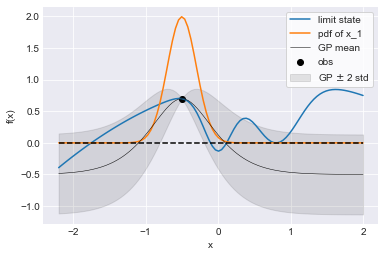

In [3]:
# The input distribution
x1_mean = -0.5
x1_std = 0.2
x1_rv = stats.norm(x1_mean, x1_std)

# Set bounds based on input dist
pof_bound_limit = 1E-6
beta_bound_limit = -stats.norm.ppf(pof_bound_limit)
bounds_pof_limit = (x1_mean - beta_bound_limit*x1_std, x1_mean + beta_bound_limit*x1_std)

# Training data
x_design = np.array([x1_mean]).reshape(-1, 1)
y_design = fun_x(x_design).flatten()

# Plot GP
model = get_initial_model(x_design, y_design)
x = np.linspace(-2.2, 2, 100)
f = fun_x(x)
pdf = x1_rv.pdf(x)
m, v = model.calc_posterior(x.reshape(-1, 1), full_cov = False)

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots()
ax.plot(x, f, label = 'limit state') 
ax.plot(x, pdf, label = 'pdf of x_1')
ax.scatter(x_design.flatten(), y_design, color = 'k', label = 'obs')
ax.plot(x, np.zeros(len(x)), 'k--')
ax.plot(x, m, color = 'k', linewidth = 0.5, label = 'GP mean')
ax.fill_between(x, m - 2*np.sqrt(v), m + 2*np.sqrt(v), color = 'k', alpha = 0.1, label = 'GP $\pm$ 2 std')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')

legend = ax.legend(loc='upper right', shadow=False, fontsize=10, frameon = True)
legend.get_frame().set_facecolor('white')

In [4]:
class SRA_Example1(SRA_epistemic):
    """
    Custom model for example 1
    """
    def __init__(self, X_dist, E_dist, E_conservative, GP_model):
        """
        Input:
        
        X_dist   -  Aleatory random variable (MultivariateDistribution)
        E_dist   -  Epistemic random variable (MultivariateDistribution)
        """
        super().__init__(X_dist, E_dist, E_conservative)
        self.GP_model = GP_model
        self.limitstate_id = 0 # 0 = current, 1 = assuming new observation (x_new, y_new) in GP
        
        # Sigma points for 1d output
        self.output_points = MerweScaledSigmaPoints(1, alpha = 0.9, beta = 2, kappa = 3-1)
        self.output_sigma = self.output_points.sigma_points(0, 1).flatten()
                
    def G_e(self, X, e):
        """
        Limit state 
        
        Input: 
        
        X = N * self.X_dist.dim array of N points in X-space
        e = a single realization of the epistemic variable E
        
        Output: N-dimensional numpy array with G(X) values
        """
        
        if self.limitstate_id == 0:
            m, v = self.GP_model.calc_posterior(X.reshape(-1, 1), full_cov = False)
        else:
            m, v = self.GP_model.calc_posterior_new(X.reshape(-1, 1))
            
        g = m + e[0]*np.sqrt(v)
        return g
    
    def UT_acq(self, x_new):
        """
        Compute E[var[pof]] 2 SUR criteria based on Bernoulli variance assuming a new observation at x_new
        """
        
        tmp = self.limitstate_id
        self.limitstate_id = 1
        
        # Set x_new
        self.GP_model.set_x_new(x_new)
        
        # Get mean and std of response
        m, v = self.GP_model.calc_posterior(x_new.reshape(1, -1) , full_cov = False)

        y = m + self.output_sigma*np.sqrt(v)

        var_pof = np.zeros(3)
        J1 = np.zeros(3)
        J2 = np.zeros(3)
        for i in range(len(y)):
            self.GP_model.set_y_new(y[i])
            
            PoF_mean, PoF_var = self.UT_pof_moments() # Compute mean and var of PoF assuming y_new = y[i]
            var_pof[i] = PoF_var
            
            j1, j2 = self.bernoulli_var()
            J1[i] = j1
            J2[i] = j2
            
        
        mean, var = unscented_transform(var_pof.reshape(1, -1).T, self.output_points.Wm, self.output_points.Wc)
        e_var_pof = mean[0]
        
        mean_J1, var_J1 = unscented_transform(J1.reshape(1, -1).T, self.output_points.Wm, self.output_points.Wc)
        mean_J2, var_J2 = unscented_transform(J2.reshape(1, -1).T, self.output_points.Wm, self.output_points.Wc)
        
        self.limitstate_id = tmp

        return e_var_pof, mean_J1[0], mean_J2[0]
    
    def UT_g_moments(self, X):
        """
        Estimate E[g(X)], Var[g(X)] with respect to epistemic uncertainties using UT
        """
        
        # In this example we can just use the GP, so we overload this method
        if self.limitstate_id == 0:
            m, v = self.GP_model.calc_posterior(X.reshape(-1, 1), full_cov = False)
        else:
            m, v = self.GP_model.calc_posterior_new(X.reshape(-1, 1))
            
        return m, v
    

In [5]:
def find_next_x(bounds_pof_limit, SRA_MODEL, n = 100):
    """
    Find next x value
    """
    SRA_MODEL.limitstate_id = 1
    x = np.linspace(bounds_pof_limit[0], bounds_pof_limit[1], n) # Search here
    y = np.array([SRA_MODEL.UT_acq(xx) for xx in x])[:,0]
    idx = y.argmin()
    x_new = x[idx]
    SRA_MODEL.limitstate_id = 0
    return np.array([x_new])

def compute_acq(x, SRA_MODEL):
    """
    Compute acquisition functions at x for SRA_MODEL
    """
    y = np.array([SRA_MODEL.UT_acq(xx) for xx in x])
    E_var_pof = y[:,0]
    J1 = y[:,1]
    J2 = y[:,2]
    
    return E_var_pof, J1, J2

def update_model(x_new, y_new, SRA_MODEL):
    SRA_MODEL.GP_model.reset()
    SRA_MODEL.GP_model.X_training = np.append(SRA_MODEL.GP_model.X_training, x_new.reshape(1, -1), axis = 0)
    SRA_MODEL.GP_model.Y_training = np.append(SRA_MODEL.GP_model.Y_training, y_new)
    
def compute_pof(SRA_MODEL):
    SRA_MODEL.limitstate_id = 0
    PoF_mean, PoF_var = SRA_MODEL.UT_pof_moments()
    
    return PoF_mean, PoF_var

In [6]:
# Create initial SRA model for example 1
X_dist = MultivariateDistribution()
X_dist.AddVariable(Normal('x1', x1_mean, x1_std))

E_dist = MultivariateDistribution()
E_dist.AddVariable(Normal('e1', 0, 1))

E_conservative = [np.array([-2]), np.array([-1]), np.array([-1.5])]

SRA_MODEL_TRUE = SRA_baseclass


In [7]:
# Compute "true" pof
SRA_MODEL_TRUE = SRA_baseclass(X_dist, fun_x)
conv, beta_FORM, pof_FORM = SRA_MODEL_TRUE.Run_FORM()
print('*** FORM ***')
print('FORM convergence:', conv)
print('FORM beta:', beta_FORM)
print('FORM pof', pof_FORM)

beta_MC, pof_MC, cov_MC = SRA_MODEL_TRUE.Run_MC(10000)
print()
print('*** Crude MC ***')
print('MC beta:', beta_MC)
print('MC pof:', pof_MC)
print('MC cov:', cov_MC)
print()

# ..some intermediate results from FORM
print()
print('* Sensitivity vector etc. from MPP search *')
for key, val in SRA_MODEL_TRUE._results_MPP.items():
    print(key + ':', val)

beta_MC, pof_MC, cov_MC = SRA_MODEL_TRUE.Run_MCIS(100000, SRA_MODEL_TRUE._results_MPP['MPP_u'])
print()
print('*** MCIS ***')
print('MC beta:', beta_MC)
print('MC pof:', pof_MC)
print('MC cov:', cov_MC)
print()

POF_TRUE = pof_MC

*** FORM ***
FORM convergence: True
FORM beta: 1.9727377156335477
FORM pof 0.0242627262915145

*** Crude MC ***
MC beta: 1.9845011501354217
MC pof: 0.0236
MC cov: 0.0643217547614586


* Sensitivity vector etc. from MPP search *
MPP_u: [1.97273772]
MPP_x: [-0.10545246]
conv: True
alpha: [1.]
err_g: [4.45457689e-05]
err_u: 0.0
num_iter: 4
num_limitstate_calls: 31

*** MCIS ***
MC beta: 1.9876307015204677
MC pof: 0.023426274115021326
MC cov: 0.005071337690247186



In [8]:
# Run experiments
N_max_runs = 5
PoF_mean = []
PoF_var = []
E_var_pof, J1, J2 = [], [], []
GP_mean, GP_var, GP_X_training, GP_Y_training = [], [], [], []
X_samples = []
X_new = []

x_plot = np.linspace(-2.2, 2, 100)
pdf_x = x1_rv.pdf(x_plot)
f = fun_x(x)

# Initial model
SRA_MODEL = SRA_Example1(X_dist, E_dist, E_conservative, get_initial_model(x_design, y_design))

# Initial samples
SRA_MODEL.generate_samples(n_MPP = 2, n_MPP_tries = 100, n_warmup = 10000, n_max = 10000)

conv = False
for i in range(N_max_runs):
    print('STARTING CASE {}'.format(i))
    
    # Compute acq for plotting
    evp, j1, j2 = compute_acq(x_plot, SRA_MODEL)
    E_var_pof.append(evp)
    J1.append(j1)
    J2.append(j2)
    
    # Compute GP for plotting
    m, v = SRA_MODEL.GP_model.calc_posterior(x_plot.reshape(-1, 1), full_cov = False)
    GP_mean.append(m)
    GP_var.append(v)
    GP_X_training.append(SRA_MODEL.GP_model.X_training.flatten())
    GP_Y_training.append(SRA_MODEL.GP_model.Y_training.flatten())
    X_samples.append(SRA_MODEL.pruned_samples_X.flatten())
    
    # Find next x
    t0 = time.time()
    print('Searching for x_new ...', end = '')
    x_new = find_next_x(bounds_pof_limit, SRA_MODEL, n = 100)
    X_new.append(x_new)
    print(' done, time = {}'.format(formattime(time.time() - t0)))
    
    # Update model
    y_new = fun_x(x_new)[0]
    update_model(x_new, y_new, SRA_MODEL)
    
    # Generate new samples
    t0 = time.time()
    print('Generating new samples ...', end = '')
    SRA_MODEL.generate_samples(n_MPP = 2, n_MPP_tries = 100, n_warmup = 10000, n_max = 10000)
    print(' done, time = {}'.format(formattime(time.time() - t0)))
    
    # Compute estimate of pof
    m, v = compute_pof(SRA_MODEL)
    PoF_mean.append(m)
    PoF_var.append(v)
    
    # Stopping criterion
    if np.sqrt(v)/m < 0.05:
        conv = True
        break

# Save final GP
evp, j1, j2 = compute_acq(x_plot, SRA_MODEL)
E_var_pof.append(evp)
J1.append(j1)
J2.append(j2)
m, v = SRA_MODEL.GP_model.calc_posterior(x_plot.reshape(-1, 1), full_cov = False)
GP_mean.append(m)
GP_var.append(v)
GP_X_training.append(SRA_MODEL.GP_model.X_training.flatten())
GP_Y_training.append(SRA_MODEL.GP_model.Y_training.flatten())
X_samples.append(SRA_MODEL.pruned_samples_X.flatten())

# Save all results
res = {
    'conv': conv,
    'iter': i,
    'PoF_mean': PoF_mean,
    'PoF_var': PoF_var,
    'x_plot': x_plot,
    'E_var_pof': E_var_pof,
    'J1': J1,
    'J2': J2,
    'GP_mean': GP_mean,
    'GP_var': GP_var,
    'GP_X_training': GP_X_training,
    'GP_Y_training': GP_Y_training,
    'pdf_x': pdf_x,
    'X_samples': X_samples,
    'fun_true': f,
    'X_new': X_new
}

print('DONE, convergence = ', conv)

STARTING CASE 0
Searching for x_new ... done, time = 0.931 seconds
Generating new samples ... done, time = 0.016 seconds
STARTING CASE 1
Searching for x_new ... done, time = 0.833 seconds
Generating new samples ... done, time = 0.016 seconds
STARTING CASE 2
Searching for x_new ... done, time = 0.948 seconds
Generating new samples ... done, time = 0.016 seconds
DONE, convergence =  True


## Plot each iteration

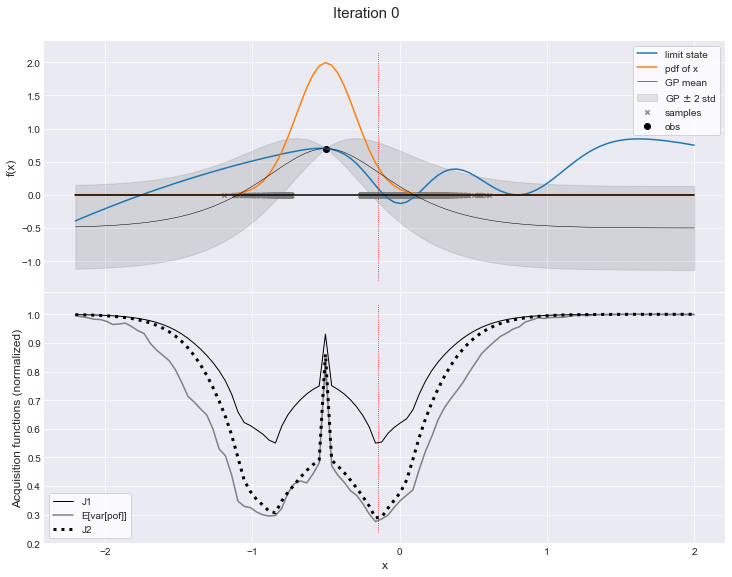

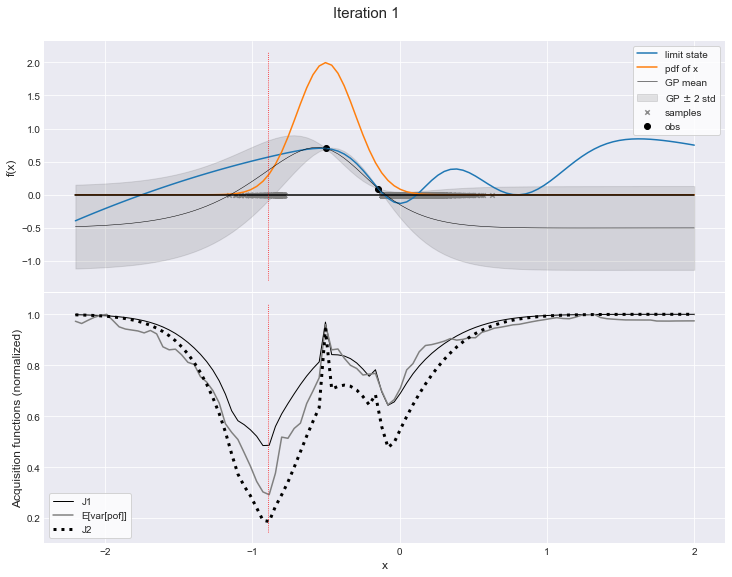

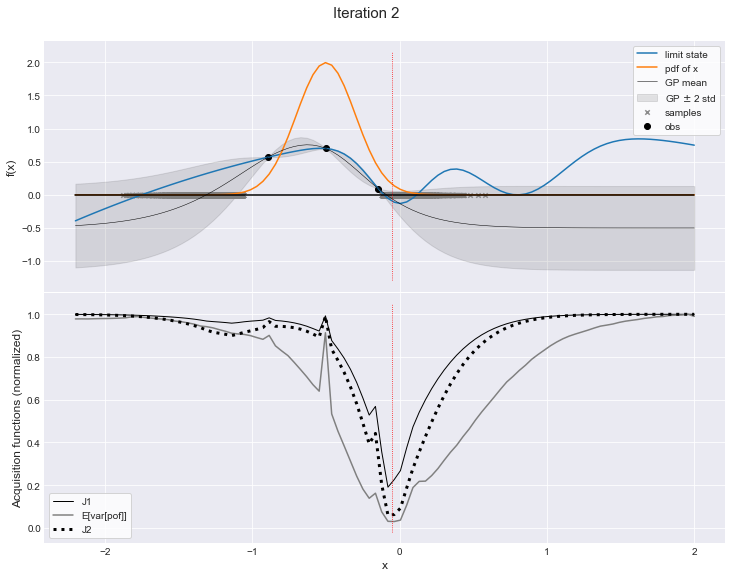

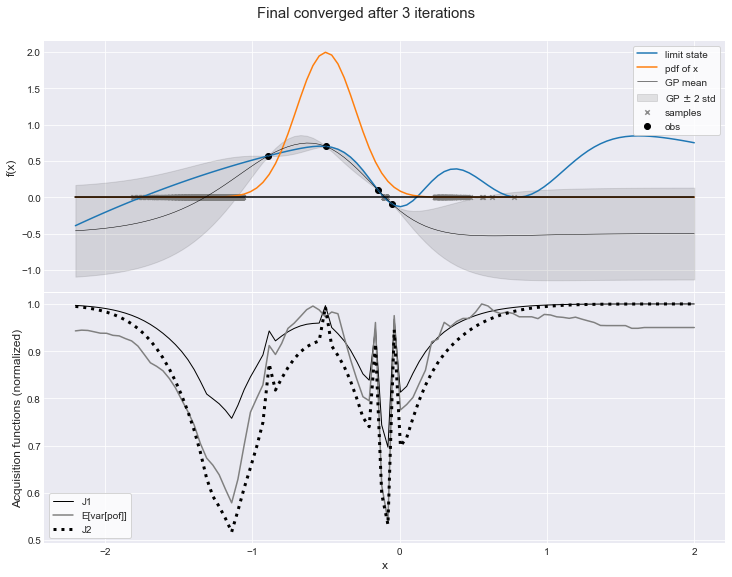

In [10]:
# Plot all steps
from matplotlib.ticker import MaxNLocator

def normalize(y):
    return y/np.max(y)

def plot_case(idx, title, include_x_new = True):
    
    x = res['x_plot']
    m, v = res['GP_mean'][idx], res['GP_var'][idx]
    
    fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10,8))
    ax = axs.ravel()
    
    ax[0].plot(x, res['fun_true'], label = 'limit state') 
    ax[0].plot(x, res['pdf_x'], label = 'pdf of x')
    ax[0].plot(x, np.zeros(len(x)), 'k')
    ax[0].plot(x, m, color = 'k', linewidth = 0.5, label = 'GP mean')
    ax[0].fill_between(x, m - 2*np.sqrt(v), m + 2*np.sqrt(v), color = 'k', alpha = 0.1, label = 'GP $\pm$ 2 std')
    ax[0].scatter(res['X_samples'][idx], np.zeros(len(res['X_samples'][idx])), color = 'gray', alpha = 0.9, marker = 'x', s = 20, label = 'samples')
    ax[0].scatter(res['GP_X_training'][idx], res['GP_Y_training'][idx], color = 'k', label = 'obs')
    
    ax[1].set_xlabel('x', fontsize = 12)
    ax[0].set_ylabel('f(x)', fontsize = 12)
    ax[1].set_ylabel('Acquisition functions (normalized)', fontsize = 12)

    legend = ax[0].legend(loc='best', shadow=False, fontsize=10, frameon = True)
    legend.get_frame().set_facecolor('white')
    
    
    ax[1].plot(x, normalize(res['J1'][idx]), label = 'J1', color = 'k', linestyle = '-', linewidth = 1)
    ax[1].plot(x, normalize(res['E_var_pof'][idx]), label = 'E[var[pof]]', color = 'gray', linewidth = 1.5)
    ax[1].plot(x, normalize(res['J2'][idx]), label = 'J2', color = 'k', linestyle = ':', linewidth = 3)   
    
    legend = ax[1].legend(loc='best', shadow=False, fontsize=10, frameon = True)
    legend.get_frame().set_facecolor('white')
        
    if include_x_new:
        x_new = res['X_new'][idx]
        ax[1].plot([x_new, x_new], ax[1].get_ylim(), color = 'r', linestyle = ':', linewidth = 0.8)
        ax[0].plot([x_new, x_new], ax[0].get_ylim(), color = 'r', linestyle = ':', linewidth = 0.8)
    
    fig.tight_layout(pad=0.1)
    fig.suptitle(title, fontsize = 15)
    fig.subplots_adjust(top=0.92)


for i in range(res['iter']+1): 
    plot_case(i, 'Iteration {}'.format(i))


plot_case(res['iter']+1, 'Final converged after {} iterations'.format(res['iter']+1), False)    